In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

2024-04-30 19:01:50.470511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 19:01:51.593505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

Data types in 'indu' dataframe:
Time       datetime64[ns]
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
dtype: object

Data types in 'cons' dataframe:
Time        datetime64[ns]
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
cons_Q4            float64
cons_Q5            float64
cons_Q6            float64
cons_Q7            float64
cons_Q8            float64
cons_Q9            float64
cons_Q10           float64
cons_Q11           float64
cons_Q12           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
Time       datetime64[ns]
dtype: object
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
con

In [4]:
#Split the data into training and testing sets
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2020-01-01')]
indu_test = indu[(indu['Time'] >= '2020-01-01')]

cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2020-01-01')]
cons_test = cons[(cons['Time'] >= '2020-01-01')]

gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2020-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2020-01-01')]

#Printing the length of the training and testing data
print("indu lenght: ", len(indu_train), " cons lenght: ", len(cons_train)," gdp lenght: ", len(gdp_train))
print("indu lenght: ", len(indu_test), " cons lenght: ", len(cons_test)," gdp lenght: ", len(gdp_test))

#Since gdp is not stationary, we will take the first difference
gdp_train['Value_diff'] = gdp_train['Value'].diff().fillna(0)

indu lenght:  120  cons lenght:  120  gdp lenght:  120
indu lenght:  16  cons lenght:  16  gdp lenght:  16


In [5]:
#Creating quarterly dummies
quarters = pd.date_range(start='1990-01-01', end='2023-12-31', freq='Q')
quarter_dummies = pd.get_dummies(quarters.quarter, prefix='Quarter')

# Convert the dummies from boolean values to integer
quarter_dummies = quarter_dummies.astype(int)

In [6]:
# Combine the explanatory data into one train dataframe
exog_train = pd.merge(indu_train, cons_train, on='Time')
exog_train = exog_train.drop(['Time'], axis=1)
# Adding the quarterly dummy variables
quarter_dummies_train = quarter_dummies.head(len(exog_train)).copy()
exog_train = pd.merge(exog_train, quarter_dummies_train, left_index=True, right_index=True)

# Combine the explanatory data into one test dataframe
exog_test = pd.merge(indu_test, cons_test, on='Time')
exog_test = exog_test.drop(['Time'], axis=1)
# Adding the quarterly dummy variables
quarter_dummies_test = quarter_dummies.tail(len(exog_test)).copy()
quarter_dummies_test.reset_index(inplace=True, drop=True)  # Reset index and drop the old index
exog_test = pd.merge(exog_test, quarter_dummies_test, left_index=True, right_index=True)

# Reshape input data for LSTM
exog_train_reshaped = exog_train.values.reshape((exog_train.shape[0], 1, exog_train.shape[1]))
exog_test_reshaped = exog_test.values.reshape((exog_test.shape[0], 1, exog_test.shape[1]))

# Extract the target variable
endog_train = gdp_train['Value_diff']
endog_test = gdp_test['Value']

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(1, exog_train.shape[1]), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)),
    Dense(units=1, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42))
])

# Compile the model
model.compile(optimizer=Adam(), loss=MeanSquaredError())

# Train the model
model.fit(exog_train_reshaped, endog_train, epochs=100, batch_size=32, verbose=0)

# Forecasting the GDP
y_pred = model.predict(exog_test_reshaped)

# Reversing the first difference
y_pred_norm = np.cumsum(y_pred) + gdp_test['Value'].iloc[0]

# Calculating the RMSE
rmse_value = rmse(endog_test, y_pred_norm)
# Calculating the MAPE
mape_value = mean_absolute_percentage_error(endog_test, y_pred_norm) * 100 # Multiplying by 100 to get percentage

print("The RMSE of the model is:", rmse_value)
print("The MAPE of the model is:", mape_value)

#The RMSE of the model is 107. The model i not very accurate.
#The MAPE of the model is 14%. The model is 14% off on average.

2024-04-30 19:01:54.088084: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
The RMSE of the model is: 93.83513796669783
The MAPE of the model is: 11.72093301944792


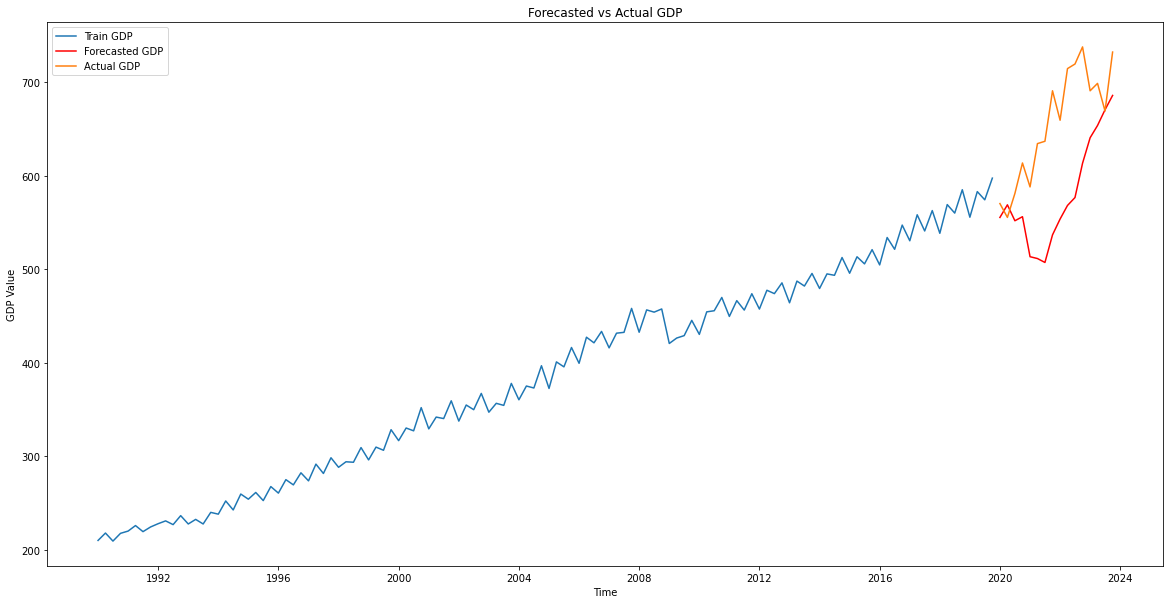

In [7]:
# Plotting the results against the actual values
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'].to_numpy(), gdp_train['Value'].to_numpy(), label='Train GDP')
plt.plot(gdp_test['Time'].to_numpy(), y_pred_norm, label='Forecasted GDP', color='red')
plt.plot(gdp_test['Time'].to_numpy(), gdp_test['Value'].to_numpy(), label='Actual GDP')
plt.xlabel('Time')
plt.ylabel('GDP Value')
plt.title('Forecasted vs Actual GDP')
plt.legend(loc='upper left')
plt.show()



In [8]:
import os
import json

#Define the evaluation metric name for this model
metric_name = "Multi_All_Post_LSTM"

# Create a dictionary with the MAPE value

# Get the current directory
current_dir = os.getcwd()

# Navigate to the directory where mape_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'mape_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the MAPE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the MAPE value to the dictionary with a corresponding key
data[metric_name] = mape_value

# Write the MAPE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)

# Create a dictionary with the RMSE value

# Navigate to the directory where rsme_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'rsme_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the RMSE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the RMSE value to the dictionary with a corresponding key
data[metric_name] = rmse_value

# Write the RMSE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)